**Loading Dataset**

In [1]:
import pandas as pd
df = pd.read_csv("/content/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [2]:
df.dtypes

,0
num_passengers,int64
sales_channel,object
trip_type,object
purchase_lead,int64
length_of_stay,int64
flight_hour,int64
flight_day,object
route,object
booking_origin,object
wants_extra_baggage,int64


In [3]:
df.columns

Index(['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead',
       'length_of_stay', 'flight_hour', 'flight_day', 'route',
       'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'flight_duration', 'booking_complete'],
      dtype='object')

In [4]:
df['trip_type'].unique()

array(['RoundTrip', 'CircleTrip', 'OneWay'], dtype=object)

**Spliting Data and performing EDA**

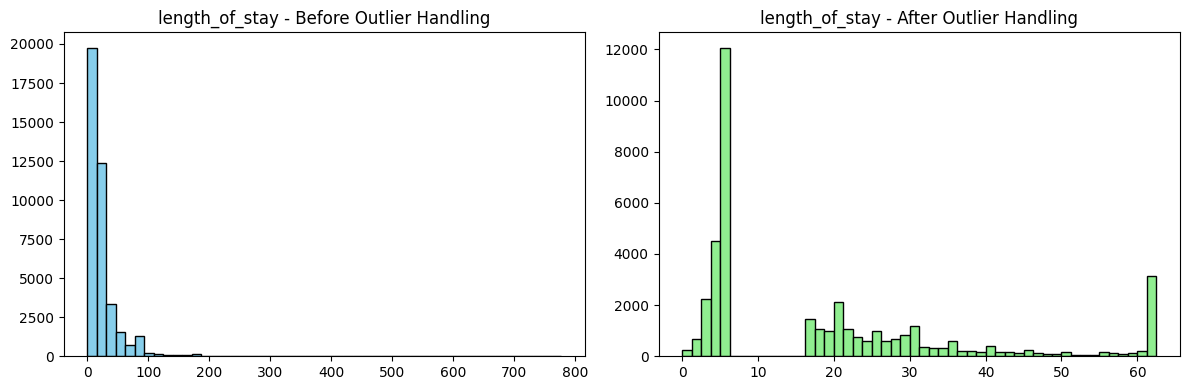

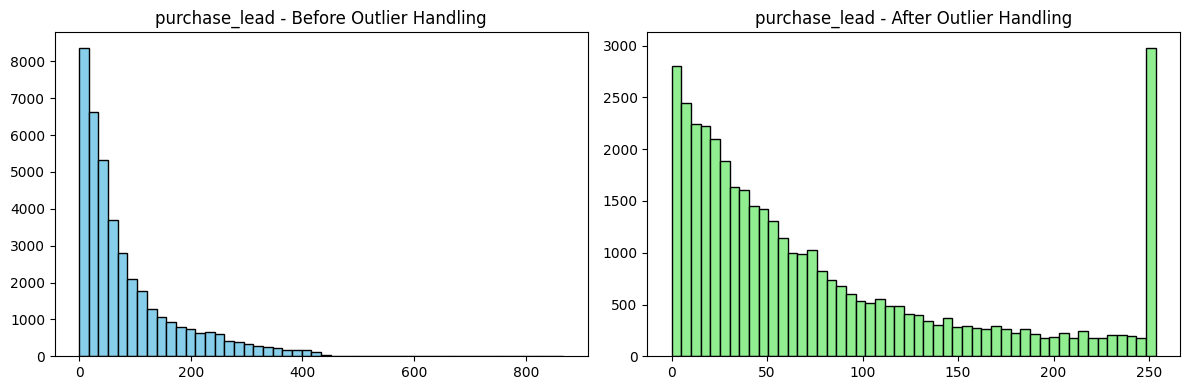

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import pointbiserialr
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import chi2
import numpy as np
import matplotlib.pyplot as plt
# Drop target and unrelated columns for features
X_booking = df.drop(['wants_extra_baggage'], axis=1)
# Target variable
y = df[['wants_extra_baggage']]


# Split BEFORE feature engineering (to avoid leakage)
X_train, X_test, y_train, y_test = train_test_split(X_booking, y, stratify=y, test_size=0.2, random_state=42)
def clip_iqr(series, max_cap=None):
    # Store original values for visualization
    original_series = series.copy()

    # Calculate IQR limits
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    upper = min(Q3 + 1.5 * IQR, max_cap) if max_cap else Q3 + 1.5 * IQR

    # Clip series
    clipped_series = series.clip(lower=0, upper=upper)

    # Plot distribution before and after
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].hist(original_series, bins=50, color='skyblue', edgecolor='black')
    axes[0].set_title(f"{series.name} - Before Outlier Handling")
    axes[1].hist(clipped_series, bins=50, color='lightgreen', edgecolor='black')
    axes[1].set_title(f"{series.name} - After Outlier Handling")
    plt.tight_layout()
    plt.show()

    return clipped_series, (0, upper)

# Apply and visualize for both columns
X_train['length_of_stay'], stay_limits = clip_iqr(X_train['length_of_stay'], 90)
X_test['length_of_stay'] = X_test['length_of_stay'].clip(*stay_limits)

X_train['purchase_lead'], lead_limits = clip_iqr(X_train['purchase_lead'], 355)
X_test['purchase_lead'] = X_test['purchase_lead'].clip(*lead_limits)

**Feature Engineering**

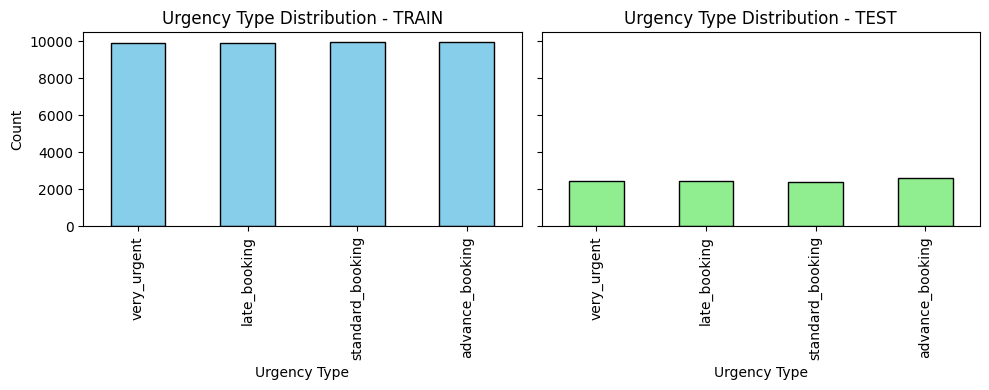

In [6]:
# Puchase lead to urgency type ( To know how much urgent the customers are booking the flight)
bins = pd.qcut(X_train['purchase_lead'], q=4, retbins=True)[1]
labels = ['very_urgent', 'late_booking', 'standard_booking', 'advance_booking']
X_train['urgency_type'] = pd.cut(X_train['purchase_lead'], bins=bins, labels=labels)
X_test['urgency_type'] = pd.cut(X_test['purchase_lead'], bins=bins, labels=labels)

# Drop purchase_lead (now binned)
X_train = X_train.drop('purchase_lead', axis=1)
X_test = X_test.drop('purchase_lead', axis=1)


import matplotlib.pyplot as plt

# After creating urgency_type in train and test
# Visualize distribution for both datasets
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Plot for training set
X_train['urgency_type'].value_counts().reindex(['very_urgent', 'late_booking', 'standard_booking', 'advance_booking']).plot(
    kind='bar', ax=axes[0], color='skyblue', edgecolor='black'
)
axes[0].set_title("Urgency Type Distribution - TRAIN")
axes[0].set_xlabel("Urgency Type")
axes[0].set_ylabel("Count")

# Plot for testing set
X_test['urgency_type'].value_counts().reindex(['very_urgent', 'late_booking', 'standard_booking', 'advance_booking']).plot(
    kind='bar', ax=axes[1], color='lightgreen', edgecolor='black'
)
axes[1].set_title("Urgency Type Distribution - TEST")
axes[1].set_xlabel("Urgency Type")

plt.tight_layout()
plt.show()


In [7]:
import matplotlib.pyplot as plt
# MAp fight day
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}
X_train["flight_day"] = X_train["flight_day"].map(mapping)
X_test["flight_day"] = X_test["flight_day"].map(mapping)

# Weekday (0) vs Weekend (1)
X_train['day_type'] = X_train['flight_day'].apply(lambda x: "Weekend" if x in [6, 7] else "Weekday")
X_test['day_type'] = X_test['flight_day'].apply(lambda x: "Weekend" if x in [6, 7] else "Weekday")
X_train = X_train.drop('flight_day', axis=1)
X_test = X_test.drop('flight_day', axis=1)

# Visualization
print("\n Class dirstribution in train ")
print(X_train['day_type'].value_counts(normalize=True)*100)
print("\n Class dirstribution in test ")
print(X_test['day_type'].value_counts(normalize=True)*100)



 Class dirstribution in train 
day_type
Weekday    75.175
Weekend    24.825
Name: proportion, dtype: float64

 Class dirstribution in test 
day_type
Weekday    75.64
Weekend    24.36
Name: proportion, dtype: float64


**Hypothesis Testing**

In [8]:
# Hypothesis Testing
print("Hypothesis Testing")
print("\n Numeric feature coreelation over here Point-Biserial is used")
alpha=0.05
for col in X_train.select_dtypes(include='number').columns:
    if col != 'wants_extra_baggage':
        corr, p_value = pointbiserialr(y_train['wants_extra_baggage'], X_train[col])
        #Hypothesis Testing
        if p_value < alpha:
          result="Reject the Null Hypothesis"
        else:
          result="Fail to Reject the Null Hypothesis"

        print(f"{col}: correlation = {corr:.3f}, p-value = {p_value:.4f} {result}")


print("\n Categorical feature correlation Chi-Square test is been used")
categorical_features = ['sales_channel', 'trip_type','urgency_type','route','booking_origin','day_type']
X_cat = X_train[categorical_features].copy()

# Encode categories as integers for Chi-Square test
encoder = LabelEncoder()
for col in X_cat.columns:
    X_cat[col] = encoder.fit_transform(X_cat[col])

# Perform Chi-Square Test
chi_scores, p_values = chi2(X_cat, y_train['wants_extra_baggage'])

def cramers_v(chi2_stat, n, k):
    return np.sqrt(chi2_stat / (n * (k - 1)))

n = len(X_cat)
for i, col in enumerate(X_cat.columns):
    chi_stat = chi_scores[i]
    p_val = p_values[i]
    k = min(X_cat[col].nunique(), y_train['wants_extra_baggage'].nunique())
    v = cramers_v(chi_stat, n, k)
    strength = (
        "Weak" if v < 0.1 else
        "Moderate" if v < 0.3 else
        "Strong" if v < 0.5 else "Very Strong"
    )
    print(f"{col}: Chi²={chi_stat:.2f}, p-value={p_val:.4f}, Cramér's V={v:.3f} ({strength})")



Hypothesis Testing

 Numeric feature coreelation over here Point-Biserial is used
num_passengers: correlation = 0.120, p-value = 0.0000 Reject the Null Hypothesis
length_of_stay: correlation = 0.246, p-value = 0.0000 Reject the Null Hypothesis
flight_hour: correlation = -0.011, p-value = 0.0351 Reject the Null Hypothesis
wants_preferred_seat: correlation = 0.206, p-value = 0.0000 Reject the Null Hypothesis
wants_in_flight_meals: correlation = 0.216, p-value = 0.0000 Reject the Null Hypothesis
flight_duration: correlation = 0.057, p-value = 0.0000 Reject the Null Hypothesis
booking_complete: correlation = 0.066, p-value = 0.0000 Reject the Null Hypothesis

 Categorical feature correlation Chi-Square test is been used
sales_channel: Chi²=99.05, p-value=0.0000, Cramér's V=0.050 (Weak)
trip_type: Chi²=0.06, p-value=0.8057, Cramér's V=0.001 (Weak)
urgency_type: Chi²=2.05, p-value=0.1517, Cramér's V=0.007 (Weak)
route: Chi²=3766.38, p-value=0.0000, Cramér's V=0.307 (Strong)
booking_origin: C

**Feature Encoding for Logistic Regression**

In [9]:
# Fit encoder on training set for logistic problem
encoder_lr = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
encoder_lr.fit(X_train[categorical_features])

def preprocess_features_logistic(df):
    df = df.copy()
    df['flight_duration_minutes'] = df['flight_duration'] * 60
    df = df.drop('flight_duration', axis=1)
    # Transform categorical features with the fitted encoder
    encoded = encoder_lr.transform(df[categorical_features])
    encoded_df = pd.DataFrame(encoded, columns=encoder_lr.get_feature_names_out(categorical_features), index=df.index)

    # Drop original categorical columns and add encoded
    df = df.drop(columns=categorical_features)
    df = pd.concat([df, encoded_df], axis=1)
    # Scale numeric features
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
    scaler = StandardScaler()
    df[numeric_features] = scaler.fit_transform(df[numeric_features])

    return df
X_train_lr = preprocess_features_logistic(X_train)
X_test_lr = preprocess_features_logistic(X_test)




/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


**Feature Encoding for Random Forest**

In [10]:
# Fit encoder on training set for logistic problem
encoder_rf = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder_rf.fit(X_train[categorical_features])

def preprocess_features_Random(df):
    df = df.copy()
    df['flight_duration_minutes'] = df['flight_duration'] * 60
    df = df.drop('flight_duration', axis=1)
    # Transform categorical features with the fitted encoder
    encoded = encoder_rf.transform(df[categorical_features])
    encoded_df = pd.DataFrame(encoded, columns=encoder_rf.get_feature_names_out(categorical_features), index=df.index)

    # Drop original categorical columns and add encoded
    df = df.drop(columns=categorical_features)
    df = pd.concat([df, encoded_df], axis=1)

    return df
X_train_rf = preprocess_features_Random(X_train)
X_test_rf = preprocess_features_Random(X_test)




In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

# Sictonary to store resampled data for each target
#X_train_bal_dict = {}
#y_train_bal_dict = {}

# Loop through each binary column
#for target_col in y_train.columns:
#    smote = SMOTE(random_state=42)

    # Apply SMOTE to X_train and current target column
#    X_resampled, y_resampled = smote.fit_resample(X_train, y_train[target_col])

#    print(f"{target_col} resampled from {Counter(y_train[target_col])} to {Counter(y_resampled)}")

    # Store in  dictionary
#    X_train_bal_dict[target_col] = X_resampled
#    y_train_bal_dict[target_col] = y_resampled

**Logistic Regression**


========== wants_extra_baggage ==========
Train Accuracy: 0.6942
Test Accuracy: 0.6865

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.72      0.60      3312
           1       0.83      0.67      0.74      6688

    accuracy                           0.69     10000
   macro avg       0.67      0.70      0.67     10000
weighted avg       0.73      0.69      0.70     10000



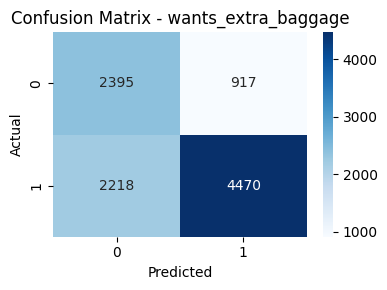

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

models_logreg = {}

for target_col in y_train.columns:
    print(f"\n========== {target_col} ==========")

    # Initialize Logistic Regression model
    clf = LogisticRegression(max_iter=1000, random_state=42,class_weight='balanced')

    # Fit on SMOTE-balanced training data
    clf.fit(X_train_lr, y_train[target_col])

    # Save the model
    models_logreg[target_col] = clf

    # Evaluate on train data
    y_train_pred = clf.predict(X_train_lr)
    train_acc = accuracy_score(y_train[target_col], y_train_pred)
    print(f"Train Accuracy: {train_acc:.4f}")

    # Evaluate on real untouched test data
    y_test_pred = clf.predict(X_test_lr)
    test_acc = accuracy_score(y_test[target_col], y_test_pred)
    print(f"Test Accuracy: {test_acc:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test[target_col], y_test_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test[target_col], y_test_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {target_col}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()




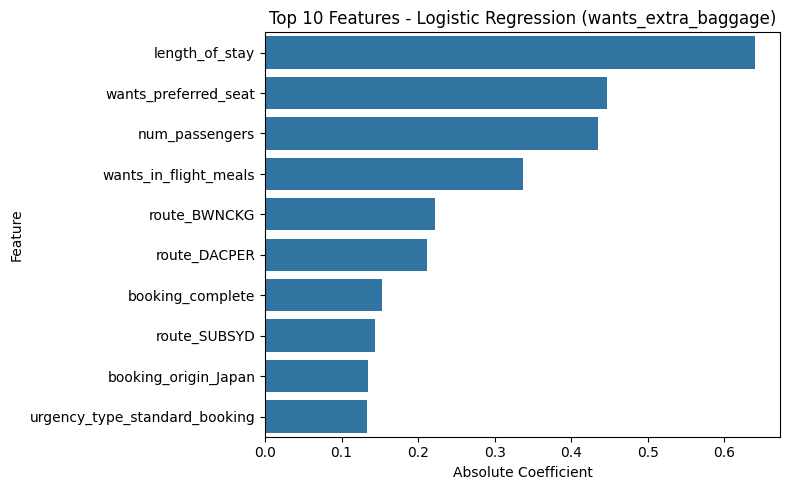

In [13]:
for target_col, model in models_logreg.items():
    coefs = pd.Series(model.coef_[0], index=X_train_lr.columns)
    top_coefs = coefs.abs().sort_values(ascending=False).head(10)

    plt.figure(figsize=(8, 5))
    sns.barplot(x=top_coefs.values, y=top_coefs.index)
    plt.title(f"Top 10 Features - Logistic Regression ({target_col})")
    plt.xlabel("Absolute Coefficient")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


**Random Forest**


========== wants_extra_baggage ==========
Train Accuracy: 0.7149
Test Accuracy: 0.6955

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.72      0.61      3312
           1       0.83      0.68      0.75      6688

    accuracy                           0.70     10000
   macro avg       0.68      0.70      0.68     10000
weighted avg       0.73      0.70      0.70     10000



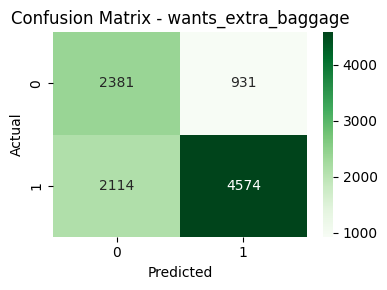

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

models_randfor = {}

for target_col in y_train.columns:
    print(f"\n========== {target_col} ==========")

    # Initialize Logistic Regression model
    clf_rf = RandomForestClassifier(
        n_estimators=500,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        class_weight='balanced'


    )

    # Fit on SMOTE-balanced training data
    clf_rf.fit(X_train_rf, y_train[target_col])

    # Save the model
    models_randfor[target_col] = clf_rf

    # Evaluate on train data
    y_train_pred = clf_rf.predict(X_train_rf)
    train_acc = accuracy_score(y_train[target_col], y_train_pred)
    print(f"Train Accuracy: {train_acc:.4f}")

    # Evaluate on real untouched test data
    y_test_pred = clf_rf.predict(X_test_rf)
    test_acc = accuracy_score(y_test[target_col], y_test_pred)
    print(f"Test Accuracy: {test_acc:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test[target_col], y_test_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test[target_col], y_test_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.title(f"Confusion Matrix - {target_col}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()




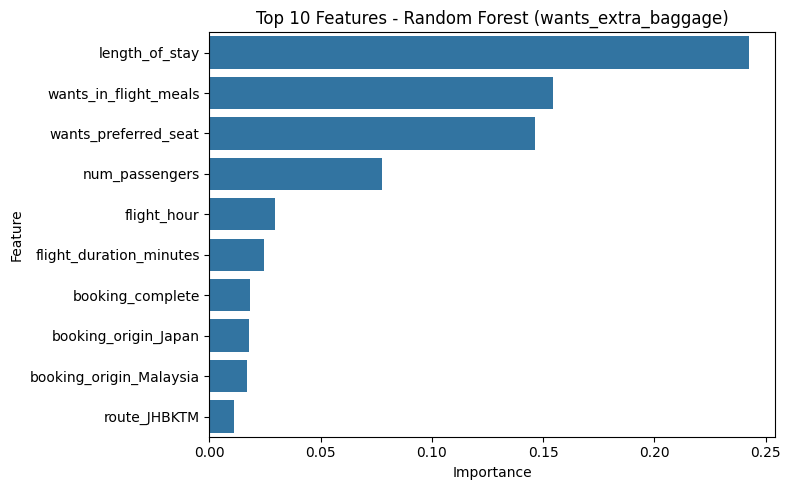


Top Features for wants_extra_baggage:
                      Feature  Importance
1             length_of_stay    0.242307
4      wants_in_flight_meals    0.154541
3       wants_preferred_seat    0.146172
0             num_passengers    0.077369
2                flight_hour    0.029676
6    flight_duration_minutes    0.024542
5           booking_complete    0.018455
849     booking_origin_Japan    0.017655
856  booking_origin_Malaysia    0.016829
479             route_JHBKTM    0.010833


In [15]:
   # Feature Importances - Top 10 (Bar Chart)
feature_importances = pd.Series(clf_rf.feature_importances_, index=X_train_rf.columns)
top_features = feature_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title(f"Top 10 Features - Random Forest ({target_col})")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



feature_names = X_train_rf.columns
sorted_idx = clf_rf.feature_importances_.argsort()
# Optional: Print feature importance values
importance_df = (
        pd.DataFrame({
            'Feature': feature_names,
            'Importance': clf_rf.feature_importances_
        }).sort_values(by='Importance', ascending=False)
    )
print(f"\nTop Features for {target_col}:\n", importance_df.head(10))